In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


In [2]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMClassifier

In [3]:
# Function to read and preprocess data
def wrangle(filepath):
    df = pd.read_csv(filepath, index_col="id")
    df = df.sort_values(by="CustomerId")
    return df


In [4]:
# Reading and preprocessing training data
df = wrangle("/kaggle/input/playground-series-s4e1/train.csv")
target = "Exited"
X = df.drop(columns=target)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# LightGBM pipeline
lgb = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    LGBMClassifier(random_state=42)
)


In [6]:
# Training and evaluating LightGBM
lgb.fit(X_train, y_train)
train_auc = roc_auc_score(y_train, lgb.predict_proba(X_train)[:, 1])
test_auc = roc_auc_score(y_test, lgb.predict_proba(X_test)[:, 1])


In [7]:
# Displaying results
print(f"Train AUC (LightGBM): {train_auc}")
print(f"Test AUC (LightGBM): {test_auc}")


Train AUC (LightGBM): 0.9022334943093565
Test AUC (LightGBM): 0.8887597548468604


/opt/conda/lib/python3.10/site-packages/category_encoders/utils.py:366: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


Text(0.5, 1.0, 'Top 15 Feature Importance (LightGBM)')

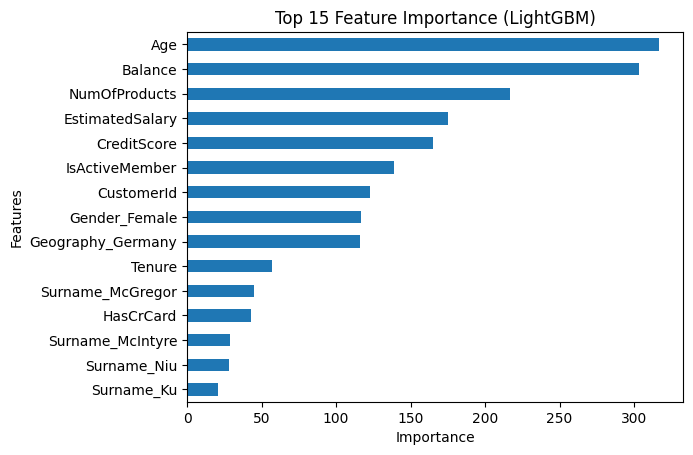

In [8]:
import matplotlib.pyplot as plt
# Plotting feature importance
imp = lgb.named_steps["lgbmclassifier"].feature_importances_
features = lgb.named_steps["onehotencoder"].get_feature_names()
feat_imp = pd.DataFrame({"Importance": imp}, index=features)
top_features = feat_imp.sort_values(by="Importance").tail(15)
top_features.plot(kind="barh", legend=False)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Top 15 Feature Importance (LightGBM)")


In [9]:
# Function to make submission
def make_submission(model, output_filename):
    test_data = wrangle("/kaggle/input/playground-series-s4e1/test.csv")
    submission = pd.DataFrame({"Exited": model.predict_proba(test_data)[:, 1]}, index=test_data.index)
    submission.to_csv(output_filename)

# Creating submission with LightGBM model
make_submission(lgb, "submission_lightgbm.csv")